# Analyzing Lease Disclosures Using NLP
This post summarizes how I study lease disclosure using Natural Language Processing techniques in my UC Berkeley Haas Dissertation, available <a href = "https://sites.google.com/view/young-yoon-brief-abstracts/home">here</a>. Using this as an example, I will explain some basic NLP processes.

# Problem Statement
Starting in 2019, the Financial Accounting Standards Board mandated firms to provide a detailed lease disclosure. Since it is the first time we are observing detailed lease information, it is important to learn the main subtopics companies disclose.

# Implementation in Python

## 1. Data 
I gathered lease footnote disclosure from the top 100 US public companies that began adopting the new lease standard in 2019.

## 2. Setup
#### 2.1. Import libraries and load the data

In [15]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the csv file that contains lease disclosures
df = pd.read_csv("lease disclosures.csv")

#### 2.2. Explore the data

In [16]:
# Display the first 5 rows
df.head()

,Numbers,Company,Symbol,Link 10-Q,AdoptionDate,LeaseFootnote
0,2.0,Apple Inc.,AAPL,https://www.sec.gov/ix?doc=/Archives/edgar/dat...,10/1/2019,The Company has lease arrangements for certain...
1,3.0,Amazon.com Inc.,AMZN,https://www.sec.gov/Archives/edgar/data/101872...,1/1/2019,We categorize leases with contractual terms lo...
2,4.0,Facebook Inc. Class A,FB,https://www.sec.gov/Archives/edgar/data/132680...,1/1/2019,We have entered into various non-cancelable op...
3,5.0,Berkshire Hathaway Inc. Class B,BRK.B,https://www.sec.gov/Archives/edgar/data/106798...,1/1/2019,We are party to contracts where we lease prope...
4,6.0,Alphabet Inc. Class A,GOOGL,https://www.sec.gov/ix?doc=/Archives/edgar/dat...,1/1/2019,We have entered into operating and finance lea...


In [17]:
# Display the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Numbers        100 non-null    float64
 1   Company        100 non-null    object 
 2   Symbol         100 non-null    object 
 3   Link 10-Q      100 non-null    object 
 4   AdoptionDate   100 non-null    object 
 5   LeaseFootnote  100 non-null    object 
dtypes: float64(1), object(5)
memory usage: 5.0+ KB


The last column is the lease disclosure. Other columns display some basic information, including company names and ticker symbols, but we don't need them. So, let's remove all other columns in the next step.

##  3. Clean the data
#### 3.1. Remove unnecessary columns

In [18]:
# Only leave the LeaseFootnote column
df = df[["LeaseFootnote"]].dropna()
df.head()

,LeaseFootnote
0,The Company has lease arrangements for certain...
1,We categorize leases with contractual terms lo...
2,We have entered into various non-cancelable op...
3,We are party to contracts where we lease prope...
4,We have entered into operating and finance lea...


#### 3.2. Inspect an example footnote

In [19]:
# Examine the first footnote 
df['LeaseFootnote'][0]

'The Company has lease arrangements for certain equipment and facilities, including retail, corporate, manufacturing and data center space. These leases typically have original terms not exceeding 10 years and generally contain multi-year renewal options, some of which are reasonably certain of exercise. The Company’s lease arrangements may contain both lease and non-lease components. The Company has elected to combine and account for lease and non-lease components as a single lease component for leases of retail, corporate, and data center facilities.\nPayments under the Company’s lease arrangements may be fixed or variable, and variable lease payments are primarily based on purchases of output of the underlying leased assets. Lease costs associated with fixed payments on the Company’s operating leases were $369 million for the three months ended December 28, 2019. Lease costs associated with variable payments on the Company’s leases were $3.0 billion for the three months ended Decemb

It looks like there are many line breaks ("/n"). Let's remove them

In [20]:
# Replace \n with an empty space
df["LeaseFootnote"] = df["LeaseFootnote"].str.replace("\n", " ")

In [21]:
# View the first footnote again
df['LeaseFootnote'][0]

'The Company has lease arrangements for certain equipment and facilities, including retail, corporate, manufacturing and data center space. These leases typically have original terms not exceeding 10 years and generally contain multi-year renewal options, some of which are reasonably certain of exercise. The Company’s lease arrangements may contain both lease and non-lease components. The Company has elected to combine and account for lease and non-lease components as a single lease component for leases of retail, corporate, and data center facilities. Payments under the Company’s lease arrangements may be fixed or variable, and variable lease payments are primarily based on purchases of output of the underlying leased assets. Lease costs associated with fixed payments on the Company’s operating leases were $369 million for the three months ended December 28, 2019. Lease costs associated with variable payments on the Company’s leases were $3.0 billion for the three months ended Decembe

Looks much better!

#### 3.3. Word count - Histogram and Kernel Density Plot
How much information do firms disclose? I am going to use word count to visualize the quantity of information.

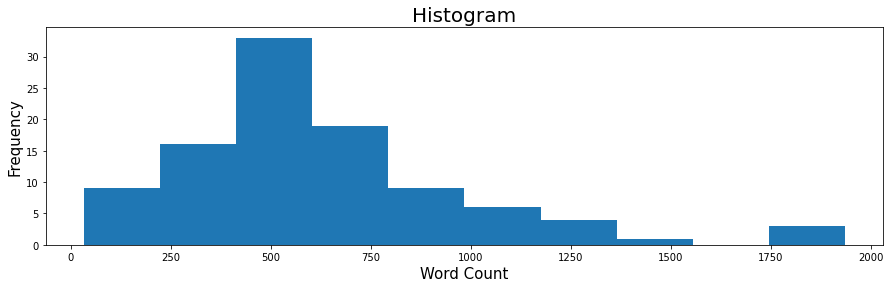

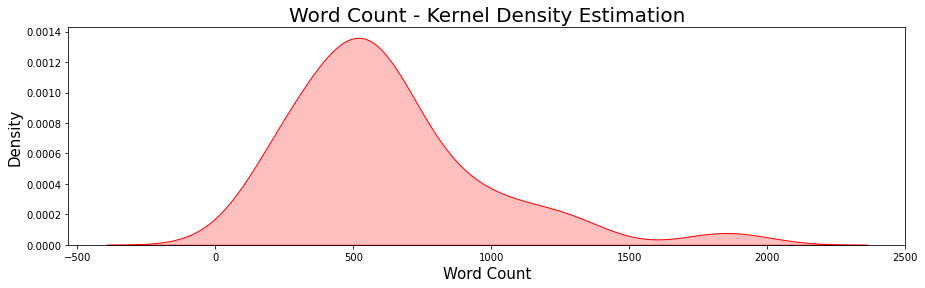

In [22]:
# Import 
import seaborn as sns

# Create a new column of word counts
df['word_count'] = df['LeaseFootnote'].str.split().str.len()

# Histogram
fig = plt.figure(figsize=(15, 4))             # Size
plt.hist(df['word_count'] )                   # Plot
plt.ylabel("Frequency", fontsize = 15)        # Y label
plt.xlabel("Word Count", fontsize = 15)       # X label
plt.title("Histogram", fontsize = 20)         # Title
plt.show()

# Kernel Density Plot
fig = plt.figure(figsize=(15, 4))             # Size
ax = sns.kdeplot(df['word_count'],            # Plot
         color = "Red", shade = True)
ax.set_ylabel("Density", fontsize = 15)       # Y label
ax.set_xlabel("Word Count", fontsize = 15)    # X label
plt.title(
    "Word Count - Kernel Density Estimation", 
    fontsize = 20)                            #title
plt.show()

In [23]:
# Descriptive stats
df['word_count'].describe()

count     100.000000
mean      621.920000
std       358.427646
min        33.000000
25%       414.750000
50%       555.000000
75%       725.500000
max      1935.000000
Name: word_count, dtype: float64

Word counts follow a normal distribution with a few outlier firms that report almost 200 words. The average firm reports around 621 words, and the interquartile range is from 415 to 725 words.

##  4. Preprocessing
A series of preprocessing steps will help us better analyze the data. The steps are as follows:
1. Convert all words to lower cases
2. Remove punctuations and numbers
3. Tokenize texts to words so that machines can work with them.
4. Remove stop words
 - There are many libraries of stop words we can import. However, because we want to make sure that we are not removing any important words, we are going to create my own list of stop words. To do so, I had to come back to this step repeatedly to add more stop words.
5. Lemmatization
 - It refers to replacing a word with its most basic form.
 
#### 4.1. Preparation

In [24]:
# Import Libraries
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')   # Required for tokenization
nltk.download('wordnet') # Required for lemmatization

# Instantiate
lemmatizer = WordNetLemmatizer()

# Create our own stop words
stop_words = (                                        \
    "\n ’ the company and of for in to a or years l   \
    other were that ended we at with our included s   \
    firm follows under consolidated have these over   \
    include billion million december which an le from \
    certain le — million had show apple including     \
    as noncurrent current total three are on not is   \
    involving millions shows centers contains      "  \
             ).split()

# Exclusion list of punctuations and numbers
exclist = string.punctuation + string.digits

# Print the exclusion list
print(exclist)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Young\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Young\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 4.2. Implement preprocessing

In [25]:
# Create a Function
def clean_texts(text):
    """ Function to perform preprocessing """
    
    # Convert to lower cases
    text = text.lower()
    
    # Remove punctuations and numbers
    text = text.translate(str.maketrans("", "", exclist))
    
    # Tokenization
    tokens = word_tokenize(text)
        
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens
    clean_text = " ".join(tokens)
    
    # Return the output
    return clean_text

# Apply the function to all disclosures
df['LeaseFootnote'] = df['LeaseFootnote'].apply(clean_texts)

# View the first 5 rows
df.head()

,LeaseFootnote,word_count
0,ha lease arrangement equipment facility retail...,468
1,categorize lease contractual term longer than ...,378
2,entered into various noncancelable operating l...,360
3,party contract where lease property others les...,291
4,entered into operating finance lease agreement...,568


## 5. Extract Key Words

#### 5.1. Word Clouds
One way to extract keywords is to examine words that are used most frequently by generating word clouds and bar plots.

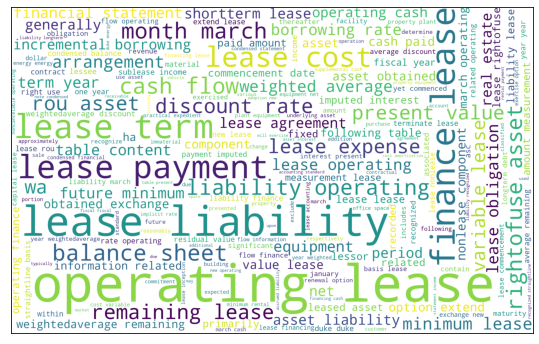

In [26]:
# Import library
from wordcloud import WordCloud
from collections import Counter

# Instantiate Word Cloud
wc = WordCloud(width=2400,
               height=1500,
               min_font_size=10,
               background_color='white')

# Generate a word cloud
plt.figure(figsize = (24, 6))
lease_wc = wc.generate(df['LeaseFootnote'].str.cat(sep=" "))
plt.xticks([])
plt.yticks([])
plt.imshow(lease_wc);

Several observations:
1. Companies discuss operating leases more often than finance leases.
2. Similarly, they discuss lease liabilities more often than ROU assets (i.e., lease assets).
3. Some other subtopics include the following
 - "lease cost" and "lease expense", which are synonyms
 - "future minimum", "remaining lease", "lease payments", "present value", "borrowing rate" (lease liabilities are determined by the taking the present value of remaining future minimum lease payments where borrowing rate is used for the present value computation)
 - "weighted average" and "lease term" 
 
From this word cloud, it is very clear what kind of subtopics are disclosed.

#### 5.2. Bar Plots
While the word cloud focused more on two-word groups, the bar chart examines the frequency of each word.

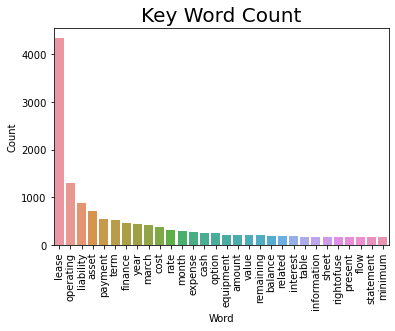

In [27]:
# Bar plot - Create a corpus of disclosures
corpus = []
for disclosures in df['LeaseFootnote'].tolist():
    for word in disclosures.split():
        corpus.append(word)

# Bar plot - Create a datafram of most common 30 words
common_words = pd.DataFrame(Counter(corpus).most_common(30))
common_words.columns = ('Word', 'Count')

# Plot a bar chart of most common 30 words
sns.barplot(x= common_words['Word'], y=common_words['Count'])
plt.xticks(rotation='vertical')
plt.title("Key Word Count", fontsize = 20)
plt.show()

Similar to the word cloud, we can infer that companies discuss the following topics (in the order of occurrences):
- operating lease
- lease liabilities
- lease assets
- operating lease payments
- remaining lease term
- operating lease cost, operating  lease expense
- discount rate

#### 5.3. TF-IDF
TFIDF is short for term frequency-inverse document frequency. It increases with the frequency of a word in a document and decreases with the number of documents that contain the word. Put differently, it adjusts for the fact that some words appear more frequently in general.

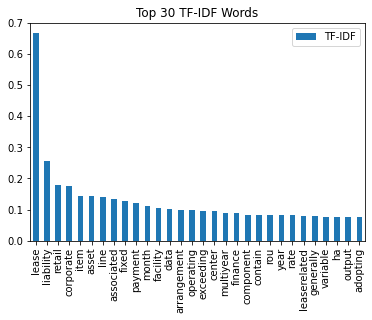

In [28]:
# Import library
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate
vectorizer = TfidfVectorizer()

# Fit the data
tfidf = vectorizer.fit_transform(df['LeaseFootnote'])

# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(), 
                      index=vectorizer.get_feature_names_out(), 
                      columns=["TF-IDF"])

# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)

# Bar Plot
tfidf_df[:30].plot.bar(title="Top 30 TF-IDF Words");

Notice that the ranks of words that appear in most of the disclosures (e.g., "operating") went down a lot. But for some words like "leases", we have high TF-IDF values because they simply appear a lot. Some interesting keywords that showed up are "retail" and "facility". We can infer that companies that have many retail spaces and facilities tend to disclose extensively about them. This makes sense because firms that rent real estate spend a significant amount on related expenses.

## 6. Inferences
To summarize, leasing disclosures contain 
- operating lease amounts (more often than finance lease amounts)
- lease liabilities (more often than lease assets)
- annual lease expenses
- various components that go into computing lease amounts
- weighted average lease term
- real estate leasees disclose heavily about retail space and facility leases
